<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/EDA_and_Dataset_Preperation_TimKong21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="polyp-segmentation:-data-exploration-and-dataset-preperation"></a>
# Polyp Segmentation: Data Exploration and Dataset Preperation

<a name="what-is-polyp-segmentation?"></a>
## What is Polyp Segmentation?
Polyp segmentation is a specific application of semantic segmentation in the field of medical imaging, particularly endoscopy. The task here is to identify and delineate the boundaries of polyps in endoscopic images. Polyps are abnormal growths in the lining of the colon that could be benign but may also turn into cancerous lesions. Therefore, their accurate and prompt identification is crucial for effective diagnosis and treatment.

<a name="about-the-dataset"></a>
## About the Dataset
The dataset used in this project is the Kvasir-SEG dataset, which is hosted by the [Simula Research Laboratory](https://datasets.simula.no/kvasir-seg/). The dataset was presented at the 32nd Scandinavian Conference on Image Analysis (SCIA 2021), which is a biennial conference on computer vision, image processing, pattern recognition and machine learning. The original paper to the dataset can be found [here](https://arxiv.org/pdf/1911.07069.pdf).

The Kvasir-SEG dataset is an open-access collection of gastrointestinal polyp images and their corresponding segmentation masks. These masks are manually annotated and verified by experienced gastroenterologists. The dataset aims to facilitate research in the field of polyp segmentation and automatic analysis of colonoscopy videos. It contains 1000 polyp images with resolutions ranging from 332x487 to 1920x1072 pixels.

The dataset is particularly useful for developing and comparing computer vision-based algorithms for segmentation, detection, localization, and classification of polyps.

<a name="objective"></a>
## Objective
The goal for this notebook is to understand and explore the polyp image data and prepare train, validation, and test sets. These data sets can be used in the next notebook to generate batches of image data that can fit into our segmentation model.

## Table of Contents
  * [Polyp Segmentation: Data Exploration and Dataset Preperation](#polyp-segmentation:-data-exploration-and-dataset-preperation)
    * [What is Polyp Segmentation?](#what-is-polyp-segmentation?)
    * [About the Dataset](#about-the-dataset)
    * [Objective](#objective)
    * [Table of Contents](#table-of-contents)
    * [Import modules](#import-modules)
    * [Configure File Accessibility](#configure-file-accessibility)
      * [Verify file format and quantity](#verify-file-format-and-quantity)
      * [Rename files](#rename-files)
      * [Remove duplicated file](#remove-duplicated-file)
      * [Set path to accessing the data](#set-path-to-accessing-the-data)
    * [Explore Image Data](#explore-image-data)
      * [Check image basic components](#check-image-basic-components)
      * [Check image width and height](#check-image-width-and-height)
      * [Check polyp positions](#check-polyp-positions)
      * [Check polyp size and count](#check-polyp-size-and-count)
      * [Check image hue, brightnesss, and saturation](#check-image-hue,-brightnesss,-and-saturation)
    * [Prepare Image Dataset](#prepare-image-dataset)
      * [Set up train test split path](#set-up-train-test-split-path)
      * [Generate test set](#generate-test-set)
      * [Generate validation set](#generate-validation-set)
      * [Generate train set](#generate-train-set)
    * [Summary](#summary)

<a name="import-modules"></a>
## Import modules

Let's first pull out the necessary modules for this notebook.

In [1]:
# File processing
import os
from glob import glob
import json
from PIL import Image
from tqdm import tqdm
import zipfile
import shutil

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="configure-file-accessibility"></a>
## Configure File Accessibility

After downloading the dataset from the Simula Research Laboratory website, the breakdown of the downloaded "Kvasir-SEG" zipped folder will be as below:
```
Kvasir-SEG
├── images
│   ├── cju0qkwl35piu0993l0dewei2.jpg
│   ├── cju0qoxqj9q6s0835b43399p4.jpg
│   ├── ...
│   
├── masks
│   ├── cju0qkwl35piu0993l0dewei2.jpg
│   ├── cju0qoxqj9q6s0835b43399p4.jpg
│   ├── ...
│
└── kavsir_bboxes.json
```

Both subfolders "images" and "masks" contain 1000 images respectively. The JSON file contains all the information about the image and the coordinate points for generating the mask.

<a name="verify-file-format-and-quantity"></a>
### Verify file format and quantity
Let's verify and see if we have correct image count and image format

In [3]:
# Download the zip file
!gdown '19jndrfhfVMbvRDLA6iyh41TiOCeIAgKh' -O \
   /tmp/kvasir-seg.zip

Downloading...
From (original): https://drive.google.com/uc?id=19jndrfhfVMbvRDLA6iyh41TiOCeIAgKh
From (redirected): https://drive.google.com/uc?id=19jndrfhfVMbvRDLA6iyh41TiOCeIAgKh&confirm=t&uuid=6fa5920b-2fcf-4c65-92b7-aec41b88d90d
To: /tmp/kvasir-seg.zip
100% 46.2M/46.2M [00:00<00:00, 149MB/s]


In [4]:
# Extract data from zip
local_zip = '/tmp/kvasir-seg.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# Define the path to the "Kvasir-SEG" directory and the "images" and "masks" subdirectories
data_dir = "/tmp/Kvasir-SEG"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

# Get a list of filenames in the "images" and "masks" subdirectories
images_files = os.listdir(images_dir)
masks_files = os.listdir(masks_dir)

# Check the file format of each image file in the images folder
images_formats = set()
for file_name in os.listdir(images_dir):
    file_path = os.path.join(images_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        images_formats.add(file_format)

# Check the file format of each image file in the masks folder
masks_formats = set()
for file_name in os.listdir(masks_dir):
    file_path = os.path.join(masks_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        masks_formats.add(file_format)

# Print the number of images and masks, along with their file formats
print(f"There are {len(images_files)} colonoscopic images with {images_formats} format")
print(f"There are {len(masks_files)} segmentation masked images with {masks_formats} format")

There are 1000 colonoscopic images with {'jpg'} format
There are 1000 segmentation masked images with {'jpg'} format


<a name="rename-files"></a>
### Rename files

Let's display the original file names

In [6]:
# Original Image file name
images_files[:5]

['cju6x0yqbvxqt0755dhxislgb.jpg',
 'cju40poe4kt9s0755f9cnm3h5.jpg',
 'cju2z9vlp9j0w0801oag91sy9.jpg',
 'cju30ov1oah920801mi8thuyg.jpg',
 'cju6xifswvwbo0987nibtdr50.jpg']

In [7]:
# Original Mask file name
masks_files[:5]

['cju6x0yqbvxqt0755dhxislgb.jpg',
 'cju40poe4kt9s0755f9cnm3h5.jpg',
 'cju2z9vlp9j0w0801oag91sy9.jpg',
 'cju30ov1oah920801mi8thuyg.jpg',
 'cju6xifswvwbo0987nibtdr50.jpg']

The original file names for both images and masks are the same, this will cause confussion in the future. Let's rename them.

In [8]:
# Define a dictionary to map the original filenames to new filenames
name_mapping = {"images": "colonoscopy_", "masks": "mask_"}

# Rename the files in the "images" subdirectory
for i, file_name in enumerate(images_files):
    old_file_path = os.path.join(images_dir, file_name)
    new_file_name = f"{name_mapping['images']}{i+1:04d}.jpg"
    new_file_path = os.path.join(images_dir, new_file_name)
    os.rename(old_file_path, new_file_path)

# Rename the files in the "masks" subdirectory
for i, file_name in enumerate(masks_files):
    old_file_path = os.path.join(masks_dir, file_name)
    new_file_name = f"{name_mapping['masks']}{i+1:04d}.jpg"
    new_file_path = os.path.join(masks_dir, new_file_name)
    os.rename(old_file_path, new_file_path)

Here's the renamed colonoscopic images

In [9]:
# Renamed image file name
images_files = os.listdir(images_dir)
images_files[:5]

['colonoscopy_0878.jpg',
 'colonoscopy_0385.jpg',
 'colonoscopy_0052.jpg',
 'colonoscopy_0015.jpg',
 'colonoscopy_0379.jpg']

Here's the renamed masked images

In [10]:
# Renamed image file name
masks_files = os.listdir(masks_dir)
masks_files[:5]

['mask_0558.jpg',
 'mask_0045.jpg',
 'mask_0863.jpg',
 'mask_0931.jpg',
 'mask_0154.jpg']

We also create a new JSON file with renamed file names

In [11]:
# Define the path to the "kavsir_bboxes.json" file
file_path = os.path.join(data_dir, "kavsir_bboxes.json")

# Check if the JSON file exists
if os.path.exists(file_path):
    # Read the JSON file
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    # Create a new dictionary to store the renamed data
    renamed_data = {}

    # Rename the serial numbers in the JSON file
    for i, (file_name, file_data) in enumerate(data.items(), start=1):
        new_file_name = f"colonoscopy_{i:04d}"
        renamed_data[new_file_name] = file_data

    # Save the renamed data to a new JSON file
    renamed_file_path = os.path.join(data_dir, "renamed_bboxes.json")
    with open(renamed_file_path, 'w') as json_file:
        json.dump(renamed_data, json_file, indent=4)

    print(f"The JSON file has been renamed and saved to {renamed_file_path}")
else:
    # Print a message indicating that the file does not exist
    print(f"The JSON file {file_path} does not exist")

The JSON file has been renamed and saved to /tmp/Kvasir-SEG/renamed_bboxes.json


Let's verify if names are changed

In [12]:
# Define the path to the "renamed_bboxes.jso" file
file_path = os.path.join(data_dir, "renamed_bboxes.json")

# Read the JSON file
with open(file_path, 'r') as json_file:
    json_object = json.load(json_file)

# Print first 5 serials
list(json_object.keys())[:5]

['colonoscopy_0001',
 'colonoscopy_0002',
 'colonoscopy_0003',
 'colonoscopy_0004',
 'colonoscopy_0005']

Now all the files have the same custom serialization format

<a name="remove-duplicated-file"></a>
### Remove duplicated file
We can now remove the old JSON file

In [13]:
# Define the path to the "kavsir_bboxes.json" file
old_path = os.path.join(data_dir, "kavsir_bboxes.json")

# Check if the file exists
if os.path.exists(old_path):
    # Remove the file if it exists
    os.remove(old_path)
    print(f"{old_path} has been removed")
else:
    # Print a message indicating that the file does not exist
    print(f"{old_path} does not exist")

/tmp/Kvasir-SEG/kavsir_bboxes.json has been removed


<a name="set-path-to-accessing-the-data"></a>
### Set path to accessing the data

Now we have the files renamed, we can set the path to the images, masks, and the JSON file

In [14]:
# Define the path to the "Kvasir-SEG" directory, "images" and "masks" subdirectories, and the JSON file
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")
images_json= os.path.join(data_dir, "renamed_bboxes.json")

# Get a list of filenames in the "images" and "masks" subdirectories
images_files = os.listdir(images_dir)
masks_files = os.listdir(masks_dir)

# Read the JSON file
with open(images_json, 'r') as json_file:
    kavsir_bboxes = json.load(json_file)

Let's check again how many images we have

In [15]:
# Print the number of images and masks
print(f"There are {len(images_files)} colonoscopic images")
print(f"There are {len(masks_files)} segmentation masked images")
print(f"The JSON file contains the mask coordinates for the {len(list(kavsir_bboxes))} colonoscopic images ")

There are 1000 colonoscopic images
There are 1000 segmentation masked images
The JSON file contains the mask coordinates for the 1000 colonoscopic images 


Note we have limited of just 1000 images, we can generate more samples using data augmentation to make our model more robust

<a name="explore-image-data"></a>
## Explore Image Data

<a name="check-image-basic-components"></a>
### Check image basic components

Let's see what makes an image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
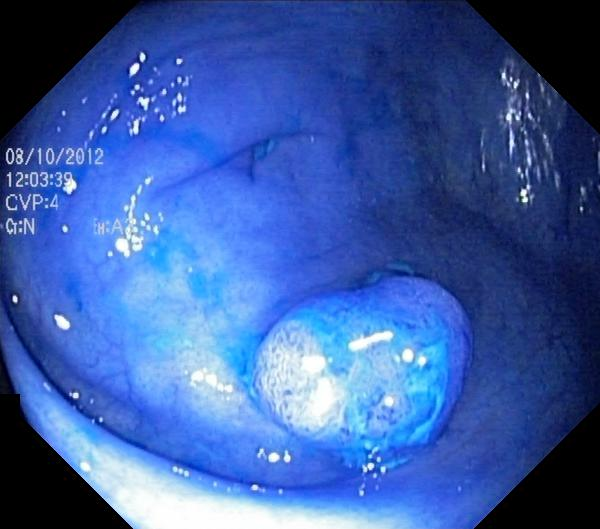

In [16]:
# Read first image from RGB colonoscopic images
cv2.imread(os.path.join(images_dir,images_files[0]))

An image is simply a matrix (or many matrices) of numbers. The numbers represent the intensity of each pixel per channel. Note that the dtype is uint8. There are a few (0,0,0)'s in the image represents the black border in the RGB image. Let's have a look at the RGB image

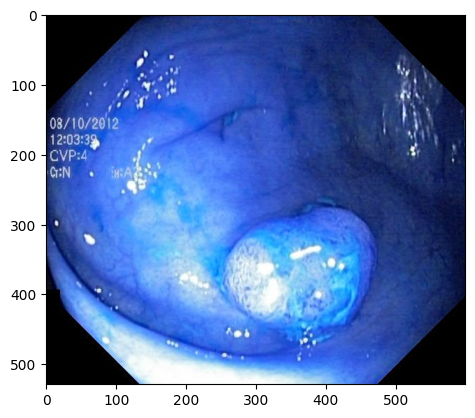

In [17]:
# Read image (BGR by default)
BGR_img1 = cv2.imread(os.path.join(images_dir,images_files[0]))

# Display image
plt.imshow(BGR_img1)
plt.show()

The above image shows blue as the 3 channels are read in reverse by OpenCv as BGR. Let's convert to RGB and visualize again

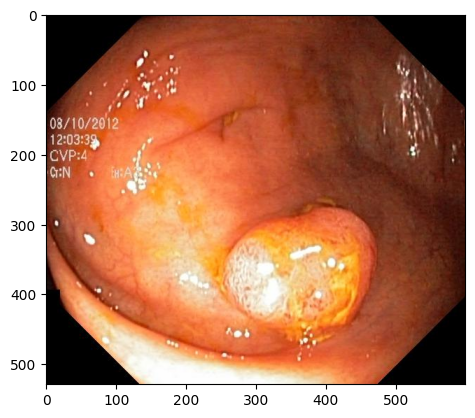

In [18]:
# Read image (BGR by default)
BGR_img1 = cv2.imread(os.path.join(images_dir,images_files[0]))

# Convert BGR to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(RGB_img1)
plt.show()

In [19]:
# Check shape of image
RGB_img1.shape

(529, 600, 3)

We see that now the image is displayed as RGB and the image has a height of 529, width of 622, and has 3 channels (RGB). Let's have  a look at its mask

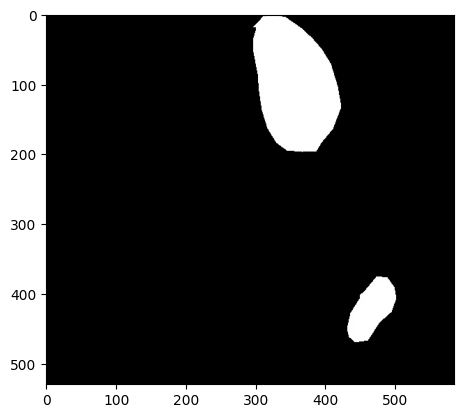

In [20]:
# Read first image from mask images
mask_img1 = cv2.imread(os.path.join(masks_dir,masks_files[0]))

# Display image
plt.imshow(mask_img1)
plt.show()

In [21]:
# Check shape of image
mask_img1.shape

(530, 585, 3)

While a grayscale image is typuically known to have 1 channel, here we our image has 3 channels because it is a colored image with the same values for all the three channels (r, g, b) in every pixel. Therefore, visually it looks like a grayscale image. Let's now check the minimum and maximum pixel value for both the RGB and mask image.

In [22]:
#Find out the min and max values of pixels in the RGB image
print('RGB Image:')
print('Image minimum value: ',RGB_img1.min())
print('Image maximum value: ',RGB_img1.max())

#Find out the min and max values of pixels in the mask image
print('Mask Image:')
print('Image minimum value: ',mask_img1.min())
print('Image maximum value: ',mask_img1.max())

RGB Image:
Image minimum value:  0
Image maximum value:  255
Mask Image:
Image minimum value:  0
Image maximum value:  255


Both the RGB and mask have the same minimum and maximum pixel value. The minimum pixel value in the image is 0 which represents black and the maximum pixel value of 255 represents white. When loading the image, we have a dtype of uint8 (unsigned), so the pixel intensity values range have $2^8$ values or 256 values to work with. Because it is unsigned, it does not have negative values.

Later when it coms to data preprocessing, we will rescale the data by dividing it by the maximum pixel value (255) before applying it to ensure that the data falls within a similar range and has a consistent scale, which can improve the performance and convergence of the model.


<a name="check-image-width-and-height"></a>
### Check image width and height

Before we dive in and look into the height and width of the masks. Let's verify if the the image and its corresponding mask have the same size (eg. size of image1 = size of mask1).

In [23]:
# Empty list to store Booleans of whether or not the size of images and masks are equal
bool_size = []

# Iterate over the image and mask files simultaneously
for image_file, mask_file in zip(images_files, masks_files):
    # Get the paths to the image and mask files
    image_path = os.path.join(images_dir, image_file)
    mask_path = os.path.join(masks_dir, mask_file)

    # Open the image and mask files
    with Image.open(image_path) as image, Image.open(mask_path) as mask:
        # Get the dimensions of the image and mask
        image_size = image.size
        mask_size = mask.size

        # Compare the dimensions
        if image_size == mask_size:
            bool_size.append(True)
        else:
            bool_size.append(False)

# Check if all elements are True
print(f"{all(bool_size)}, both images and masks have the same size.")

False, both images and masks have the same size.


We can first extract the widths and heights of all images

In [24]:
heights = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[0] for idx in range(len(images_files))]
widths = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[1] for idx in range(len(images_files))]

Now, let's see how the widths and heights are distributed

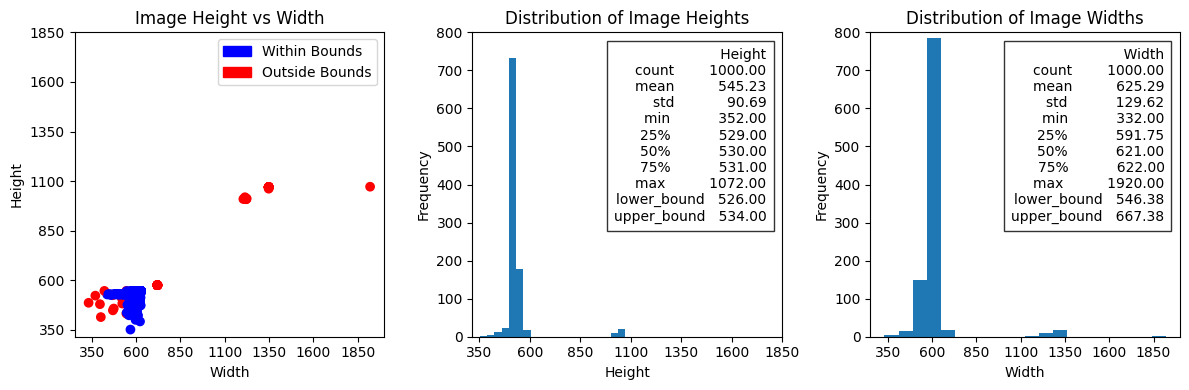

In [25]:
import matplotlib.patches as mpatches

# Create a DataFrame with heights and widths
df = pd.DataFrame({'Height': heights, 'Width': widths})

# Generate the summary statistics
summary = round(df.describe(), 2)

# Calculate the lower bound and upper bound
q1 = summary.loc['25%']
q3 = summary.loc['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Add the lower bound and upper bound to the summary
summary.loc['lower_bound'] = round(lower_bound,2)
summary.loc['upper_bound'] = round(upper_bound,2)

# Create a figure with two subplots and a scatter plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the scatter plot of heights and widths
colors = np.where((heights >= lower_bound['Height']) & (heights <= upper_bound['Height']) |
                  (widths >= lower_bound['Width']) & (widths <= upper_bound['Width']), 'blue', 'red')

scatter = axs[0].scatter(widths, heights, c=colors)
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')
axs[0].set_title('Image Height vs Width')
axs[0].set_xticks(np.arange(350, 1920, 250))
axs[0].set_yticks(np.arange(350, 1920, 250))

# Create legend labels
legend_labels = [mpatches.Patch(color='blue', label='Within Bounds'),
                 mpatches.Patch(color='red', label='Outside Bounds')]

# Add legend
axs[0].legend(handles=legend_labels)

# Plot the histogram of heights
axs[1].hist(heights, bins=20)
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Image Heights')
axs[1].set_xticks(np.arange(350, 1920, 250))
axs[1].text(0.95, 0.95, str(summary[['Height']]), transform=axs[1].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Plot the histogram of widths
axs[2].hist(widths, bins=20)
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Image Widths')
axs[2].text(0.95, 0.95,
            str(summary[['Width']]),
            transform=axs[2].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
axs[2].set_xticks(np.arange(350, 1920, 250))

# Set the same vertical scale for both histograms
axs[1].set_ylim([0, 800])
axs[2].set_ylim([0, 800])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


The samples have different sizes ranging from 332x487 to 1920x1072 pixels. Both widths and heights are right-skewed and there are some extreme outliers at far end of heights and widths.

To calculate the outliers, the lower bound and upper bound are first calculated using the interquartile range (IQR). The IQR is obtained by subtracting the 25th percentile (Q1) from the 75th percentile (Q3). The lower bound is calculated as Q1 - 1.5 * IQR, and the upper bound is calculated as Q3 + 1.5 * IQR.

Later on, we will need to resize all the images to the same size before fitting to a model for compatibility with the model architecture. Resizing the images to size within the boundary range can be an option.

<a name="check-polyp-positions"></a>
### Check polyp positions

Let's make use of the mask bounding box coordinates and see in which region are the polyps usually located at. An image can be divided to 9 grids, we then iterate over the bounding box data, calculate the center coordinates, and determine the grid cell for each bounding box based on the center coordinates.

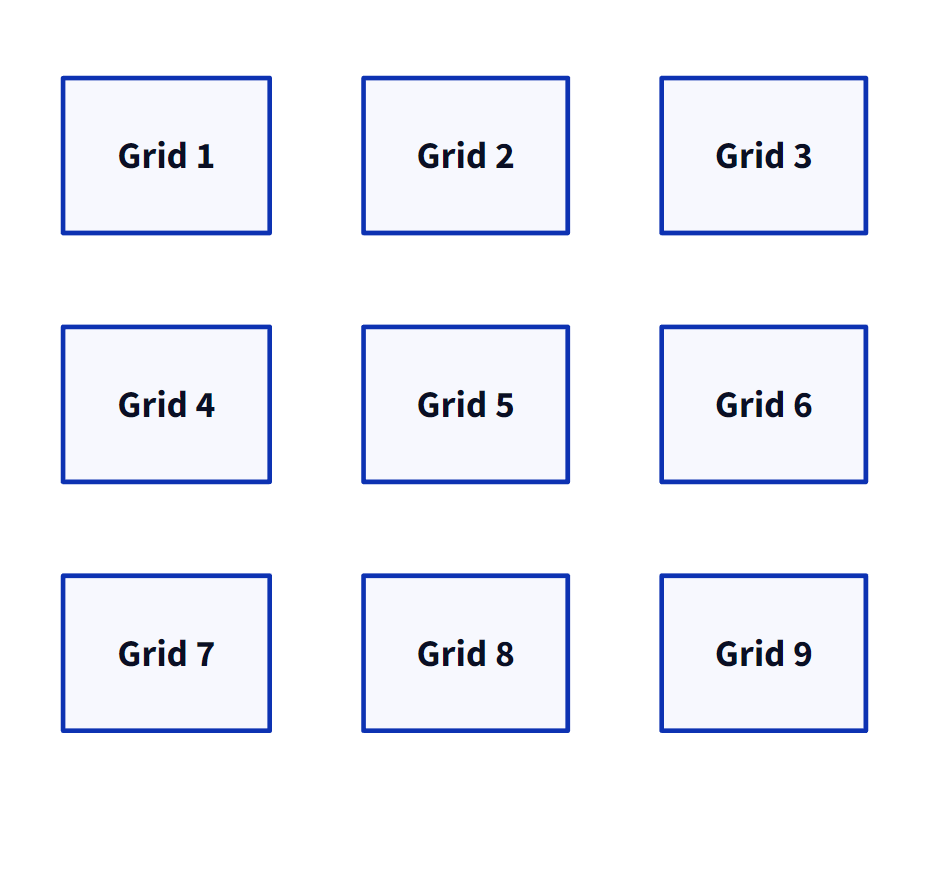

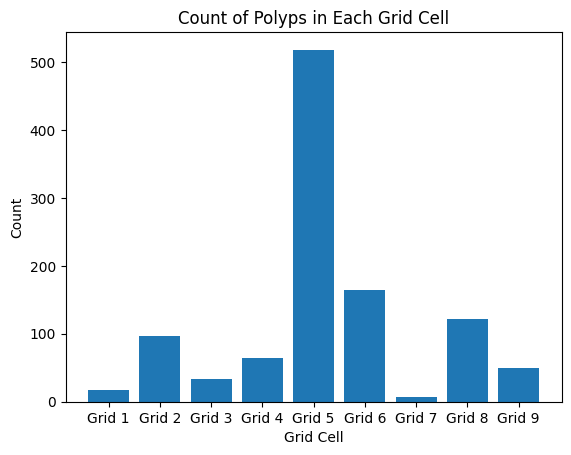

In [26]:
# Initialize a 3x3 grid to store the grid counts
grid_counts = [[0] * 3 for _ in range(3)]

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the center coordinates
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2

        # Determine the grid cell based on the center coordinates
        grid_row = int(y_center / (height / 3))
        grid_col = int(x_center / (width / 3))

        # Increment the count for the corresponding grid cell
        grid_counts[grid_row][grid_col] += 1

# Flatten the grid counts into a 1D list
counts = [count for row in grid_counts for count in row]

# Define the labels for the grid cells
labels = ['Grid {}'.format(i+1) for i in range(9)]

# Create a bar chart
x_pos = np.arange(len(labels))
plt.bar(x_pos, counts, align='center')

# Set the axis labels and title
plt.xlabel('Grid Cell')
plt.ylabel('Count')
plt.title('Count of Polyps in Each Grid Cell')

# Set the x-axis tick labels
plt.xticks(x_pos, labels)

# Display the plot
plt.show()

We can see most polyps are located in the center of the image (Grid2 = top-center, Grid5 = center-center, Grid8 = bottom-center) and least on the left side of the image (Grid1 = top-left, Grid4 = center-left, Grid7 = bottom-left)

We can better generalize our polyp position with position augmentation techniques such as flips, rotations, and translation.

<a name="check-polyp-size-and-count"></a>
### Check polyp size and count

We can get an idea of the polyp size by calculating the relative size of a bounding box. We can divide the area of the bounding box by the total area of the image, which the area of a bounding box can be computed by multiplying its width by its height.

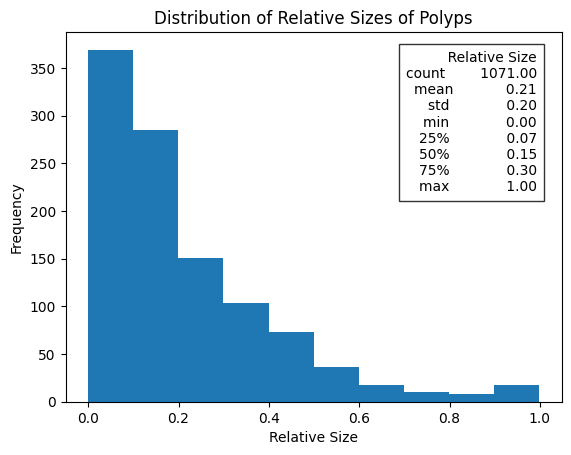

In [27]:
# Empty list to store all the relative sizes
relative_sizes = []

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the width and height of the bounding box
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin

        # Calculate the area of the bounding box
        bbox_area = bbox_width * bbox_height

        # Calculate the area of the image
        image_area = height * width

        # Calculate the relative size of the bounding box
        relative_size = bbox_area / image_area

        # Append the relative size to the list
        relative_sizes.append(relative_size)

# Calculate the summary statistics
summary = pd.DataFrame({'Relative Size': relative_sizes}).describe().round(2)

# Plot the histogram of relative sizes
n, bins, patches = plt.hist(relative_sizes)
plt.xlabel('Relative Size')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Sizes of Polyps')

# Add the summary statistics to the plot as text annotations
summary_text = str(summary[['Relative Size']])
plt.text(0.95, 0.95,
         summary_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Display the plot
plt.show()

Most relative sizes are concentrated between 0.07 to 0.30, meaning that most polyps occupy 7% to 30% of the entire image.  There are very few images with polyps occupying greater than 50% (or more) of the image.

We can also notice that the count of the polyp is 1071 when we just have 1000 images, this is because some images contain more than one polyp.For example:

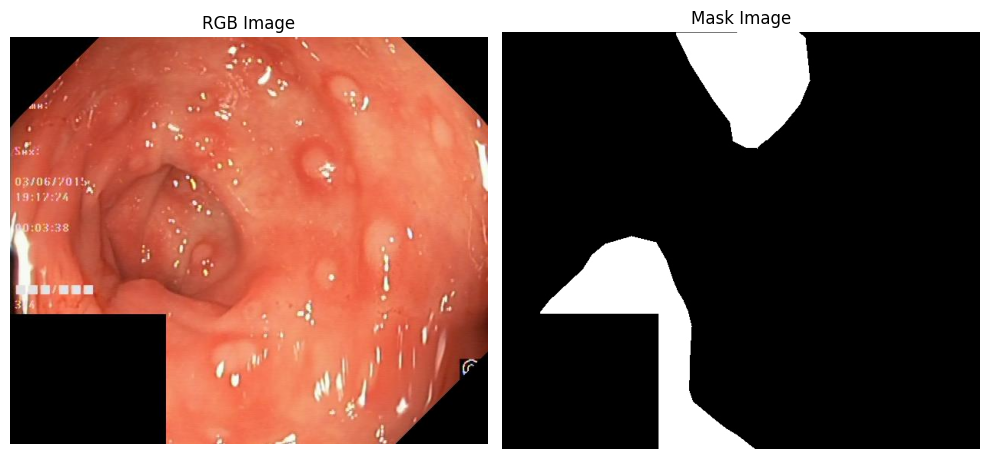

In [28]:
# Load RGB image and mask
image_path = os.path.join(images_dir, images_files[-7])
mask_path = os.path.join(masks_dir, masks_files[-7])
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB Image')
axs[0].axis('off')

# Plot the mask image
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask Image')
axs[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Overall, we can also better generalize our polyp size with position augmentation techniques such as crops and zooms.

<a name="check-image-hue,-brightnesss,-and-saturation"></a>
### Check image hue, brightnesss, and saturation

Describing colors using hue, saturation and brightness (also at times referred to as hue, saturation and lightness, or HSL) is a convenient way to organize differences in colors as perceived by humans. Explanation to each of the categories are:
- **HUE** - Hue refers to the pure state of color. It is the natural color without mixing or modifying. The unmixed or unmodified property of color is Hue. In other words, Hue is the name by which we identify a color. Also Hue is the property by which we distinguish it from other colors.

- **BRIGHTNESS (value)** - Value is the relative darkness or lightness of a color. This can be illustrated by the evidence of black and white photography of colored objects. The different colors will have different tonal values.
A scale which shows the sequence in tonal values of colors ( from White to Gray to Black) is called the GRAY SCALE. The tonal value of each color can be further affected by adding either black or white. The gradual adding of black color produces 'shades'. The gradual adding of white color produces 'Tints'. Maximum addition of white gives high tonal value. The middle colors between high and low is known as middle tones or half tone.

- **SATURATION (intensity)** - Chrome or saturation which indicates the purity of color is known as the intensity. Colors which are mixed and have ultimate degree of vividness are said to exhibit 'high intensity'. Two colors may have same hue value but yet differ in color strength.

In OpenCV, Hue has values from 0 to 180, Saturation and Value from 0 to 255. Thus, OpenCV uses HSV ranges between (0-180, 0-255, 0-255). In OpenCV, the H values 179, 178, 177 and so on are as close to the true RED as H value 1, 2, 3 and so on. Below is an example of HSV color map:

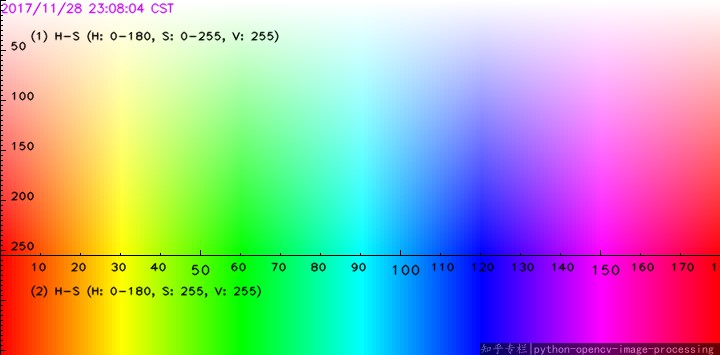

Let's plot histograms and see how are the three color components distributed for all of our RGB images

100%|██████████| 1000/1000 [00:10<00:00, 98.27it/s]


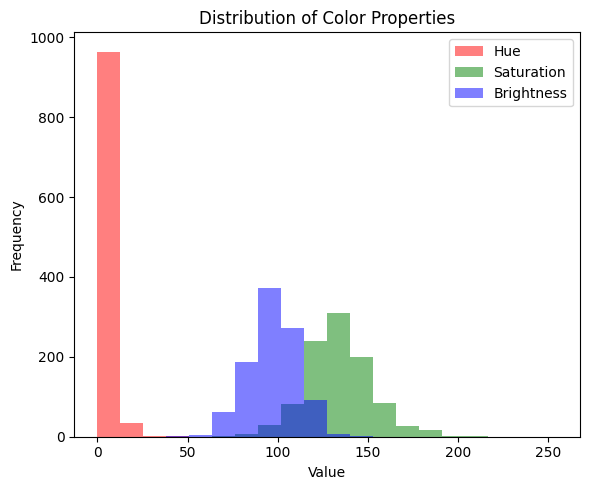

,Hue,Saturation,Brightness
count,1000.00,1000.00,1000.00
mean,9.03,134.14,97.48
std,2.40,18.28,13.46
min,4.28,75.41,48.13
25%,7.82,122.69,88.91
50%,8.65,133.69,97.60
75%,9.71,144.66,106.68
max,48.53,206.39,151.25
skewness,6.69,0.29,-0.23


In [29]:
# Calculate the average brightness, hue, and saturation of the images
brightness_values = []
hue_values = []
saturation_values = []

# Create a progress bar for the loop
for image_file in tqdm(images_files):
    # Load the image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to different color spaces
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the average pixel intensities
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Calculate the average hue value
    hue = np.mean(hsv_image[:, :, 0])
    hue_values.append(hue)

    # Calculate the average saturation value
    saturation = np.mean(hsv_image[:, :, 1])
    saturation_values.append(saturation)

# Set the same range for the x-axis
x_axis_range = (0, 255)  # Adjust this range as per your requirement

# Display the histograms of hue, saturation, and brightness values
plt.figure(figsize=(6, 5))
n, bins, patches = plt.hist(hue_values, bins=20, range=x_axis_range, color='r', alpha=0.5, label='Hue')
plt.hist(saturation_values, bins=20, range=x_axis_range, color='g', alpha=0.5, label='Saturation')
plt.hist(brightness_values, bins=20, range=x_axis_range, color='b', alpha=0.5, label='Brightness')

# Set the labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Color Properties')
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Create a DataFrame with hue, saturation, and brightness values
df = pd.DataFrame({'Hue': hue_values, 'Saturation': saturation_values, 'Brightness': brightness_values})

# Generate the summary statistics including skewness
summary = round(df.describe(), 2)
summary.loc['skewness'] = round(df.skew(), 2)

# Display the statistics
display(summary)


Let's analyze the hue, saturation, and brightness distribution.

**Hue**<br>
The hue distribution covers a wide range of values from 4.28 to 48.53. The 25th percentile (first quartile) of 7.82 and the 75th percentile (third quartile) of 9.71 suggest that most hue values fall within this range, which corresponds to red color. The longer tail towards higher hue values  indicaties that there's predominant color or color bias in that direction.


**Saturation**<br>
The distribution of saturation is fairly symmetric and has wide range of values from 75.41 to 206.39.The mean saturation value is 134.14, indicating a moderate level of saturation on average.

**Brightness**<br>
Similar to saturation, The fairly symmetric distribution of brightness indicates a relatively balanced distribution of values across the range of 48.13 to 151.25. The symmetric shape suggests that there is no strong bias towards high or low brightness values. The mean brightness value is 97.48, indicating a moderate brightness level on average.

When we get to image preprocessing, we can better generalize our hue, saturation, brightness with color augmentation.

<a name="prepare-image-dataset"></a>
## Prepare Image Dataset

We can see that our entire 1000 images and 1000 masks in two separate folders. Before fitting the images to our machine learning model, we will split the images and masks into train, validation, and test set, then apply image preprocessing and augmentation.

The purpose of a train-test split is to assess the performance and generalization ability of a machine learning model. When building a model, it is crucial to evaluate its performance on data that it has not seen during the training phase. This helps determine if the model can effectively generalize its learnings to new, unseen data.

<a name="set-up-train-test-split-path"></a>
### Set up train test split path

Before we go forward and generate the three data sets, we will first set up the train test split pipeline by the split ratio and path to save the three datasets. Below is an example of our targeted directory root tree.

```
new_data
├── test
│   ├── images
│       ├── 0011.jpg
|       ├── 0024.jpg
|       ├── ...
│   ├── masks
│       ├── 0011.jpg
|       ├── 0024.jpg
|       ├── ...
|
├── train
│   ├── images
│       ├── 0001.jpg
|       ├── 0002.jpg
|       ├── ...
│   ├── masks
│       ├── 0001.jpg
|       ├── 0002.jpg
|       ├── ...
|
├── valid
│   ├── images
│       ├── 0008.jpg
|       ├── 0009.jpg
|       ├── ...
│   ├── masks
│       ├── 0008.jpg
|       ├── 0009.jpg
|       ├── ...  
```


In [30]:
# Set the path to the dataset
full_path = "/tmp/Kvasir-SEG"

# Get the paths to the images and masks in the dataset
images = glob(os.path.join(full_path, "images/", "*"))
masks = glob(os.path.join(full_path, "masks/", "*"))

# Sort the image and mask paths
images.sort()
masks.sort()

# Define the path for the new organized dataset
new_full_path = "new_data/"
if not os.path.exists(new_full_path):
    os.mkdir(new_full_path)

# Define the paths for the training, validation, and testing sets
train_path = os.path.join(new_full_path, "train")
valid_path = os.path.join(new_full_path, "valid")
test_path = os.path.join(new_full_path, "test")

# Create the directories for the training, validation, and testing sets
if not os.path.exists(train_path):
    for path in [train_path, valid_path, test_path]:
        # os.mkdir(path)
        os.makedirs(os.path.join(path, f"images/{path.split('/')[1]}"))
        os.makedirs(os.path.join(path, f"masks/{path.split('/')[1]}"))

# Calculate the sizes of the training, validation, and testing sets
len_ids = len(images)
train_size = int((80/100) * len_ids)
valid_size = int((10/100) * len_ids)  # 10% of the images used for validation
test_size = int((10/100) * len_ids)  # 10% of the images used for testing

# Split the images and masks into training and testing sets
train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
train_masks, test_masks = train_test_split(masks, test_size=test_size, random_state=42)

# Further split the training set into training and validation sets
train_images, valid_images = train_test_split(train_images, test_size=test_size, random_state=42)
train_masks, valid_masks = train_test_split(train_masks, test_size=test_size, random_state=42)

# Print the sizes of the dataset subsets
print("Total Size: ", len_ids)
print("Training Size: ", train_size)
print("Validation Size: ", valid_size)
print("Testing Size: ", test_size)

Total Size:  1000
Training Size:  800
Validation Size:  100
Testing Size:  100


Once the pipeline's set up, let's go ahead and generate the datasets.

<a name="generate-test-set"></a>
### Generate test set

Let's split and save the test images and masks.

In [31]:
# Iterate over the test images and masks
for idx, p in tqdm(enumerate(test_images), total=len(test_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = test_images[idx]
    mask_path = test_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the test image
        image = cv2.imread(image_path)
        image_path = os.path.join(test_path, "images/test/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the test mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(test_path, "masks/test/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

100%|██████████| 100/100 [00:02<00:00, 45.85it/s]


Let's have a quick look at an example of test images and masks.

Test Image Size:  100
Test Mask Size:  100


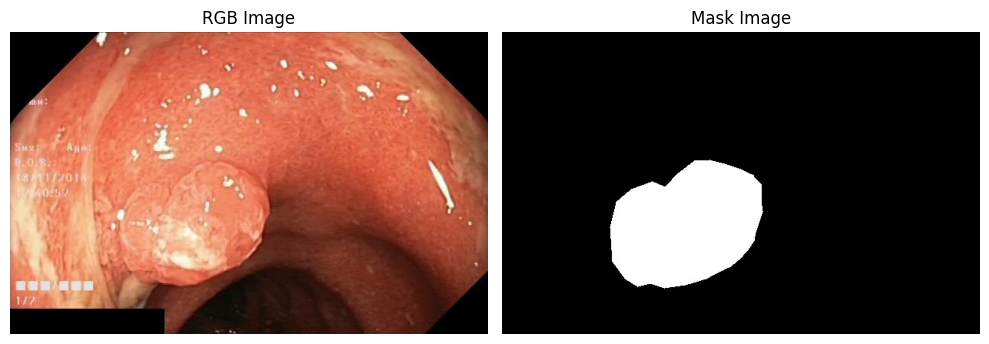

In [32]:
# Set the path to the images and masks in test directory
test_images_path = os.path.join(test_path, "images/test/")
test_images = os.listdir(test_images_path)
test_masks_path = os.path.join(test_path, "masks/test/")
test_masks = os.listdir(test_masks_path)

# Verify test mask and image sizes
print("Test Image Size: ", len(test_images))
print("Test Mask Size: ", len(test_masks))

# Read the a test image
BGR_img1 = cv2.imread(os.path.join(test_images_path, test_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read the a test mask
mask_img1 = cv2.imread(os.path.join(test_masks_path, test_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<a name="generate-validation-set"></a>
### Generate validation set

Let's split and save the validation images and masks.

In [33]:
# Iterate over the validation images and masks
for idx, p in tqdm(enumerate(valid_images), total=len(valid_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = valid_images[idx]
    mask_path = valid_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the validation image
        image = cv2.imread(image_path)
        image_path = os.path.join(valid_path, "images/valid/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the validation mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(valid_path, "masks/valid/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

100%|██████████| 100/100 [00:01<00:00, 50.77it/s]


Let's have a quick look at an example of test images and masks.

Validation Image Size:  100
Validation Mask Size:  100


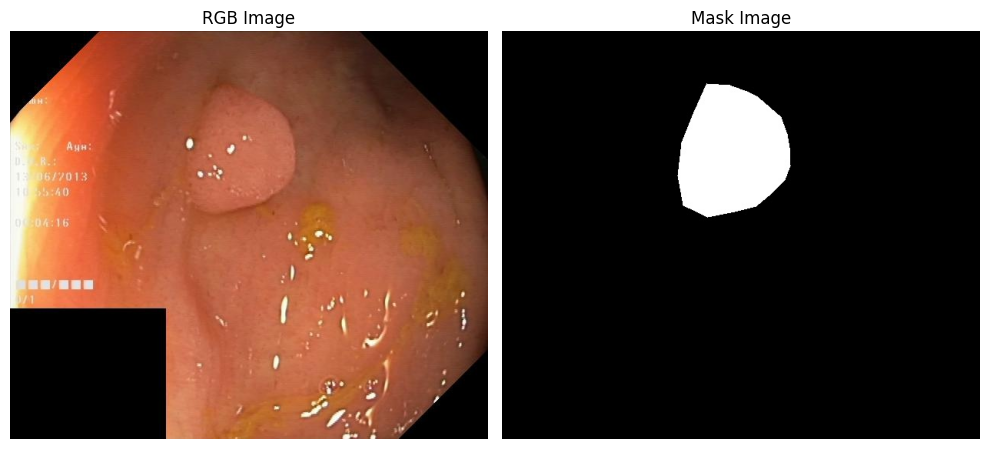

In [34]:
# Set the path to the images and masks in validation directory
valid_images_path = os.path.join(valid_path, "images/valid/")
valid_images = os.listdir(valid_images_path)
valid_masks_path = os.path.join(valid_path, "masks/valid/")
valid_masks = os.listdir(valid_masks_path)

# Verify validation mask and image sizes
print("Validation Image Size: ", len(valid_images))
print("Validation Mask Size: ", len(valid_masks))

# Read the a validation image
BGR_img1 = cv2.imread(os.path.join(valid_images_path, valid_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read the a validation mask
mask_img1 = cv2.imread(os.path.join(valid_masks_path, valid_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

<a name="generate-train-set"></a>
### Generate train set

Let's split and save the train images and masks.

In [35]:
# Iterate over the train images and masks
for idx, p in tqdm(enumerate(train_images), total=len(train_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = train_images[idx]
    mask_path = train_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the train image
        image = cv2.imread(image_path)
        image_path = os.path.join(train_path, "images/train/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the train mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(train_path, "masks/train/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

100%|██████████| 800/800 [00:17<00:00, 44.76it/s]


Let's have a quick look at an example of train images and masks.

Train Image Size:  800
Train Mask Size:  800


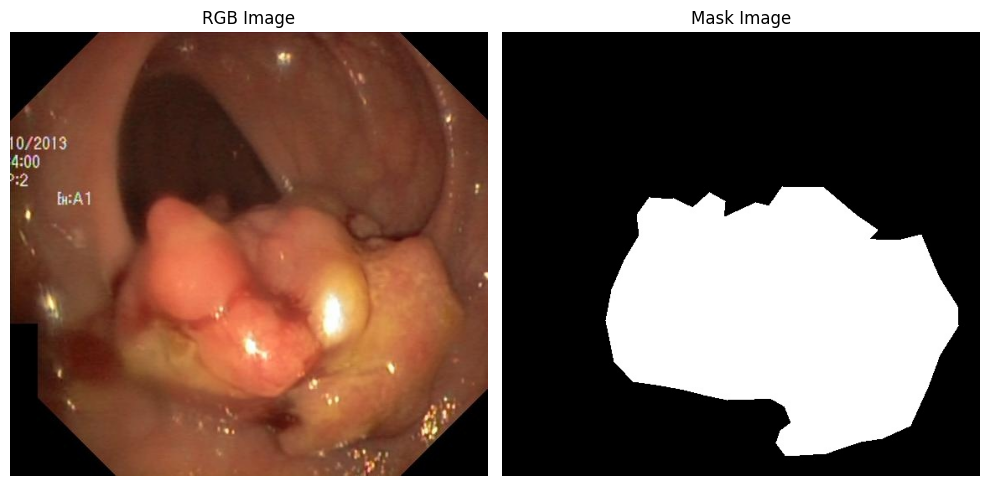

In [36]:
# Set the path to the images and masks in the train directory
train_images_path = os.path.join(train_path, "images/train/")
train_images = os.listdir(train_images_path)
train_masks_path = os.path.join(train_path, "masks/train/")
train_masks = os.listdir(train_masks_path)

# Verify train mask and image sizes
print("Train Image Size: ", len(train_images))
print("Train Mask Size: ", len(train_masks))

# Read a train image
BGR_img1 = cv2.imread(os.path.join(train_images_path, train_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read a train mask
mask_img1 = cv2.imread(os.path.join(train_masks_path, train_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [37]:
shutil.make_archive('/content/drive/MyDrive/Classroom/Monografia/datasets/kvasir-seg/new_data',
                    'zip',
                    '/content/new_data')

'/content/drive/MyDrive/Classroom/Monografia/datasets/kvasir-seg/new_data.zip'

<a name="summary"></a>
## Summary

Now we have explored the image data as well as prepared the image dataset for image preprocessing, augmentation, and modeling in the next notebook. As a summary, we have performed the following tasks:

**Exploratory Data Analysis**
- Check image basic components
- Check image width and height
- Check polyp positions
- Check polyp size and count
- Check image hue, brightness, and saturation

**Dataset Preperation**
- Generate test set
- Generate validation set
- Generate train set